<a href="https://colab.research.google.com/github/ilyayath/codefinity-test/blob/main/AB_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

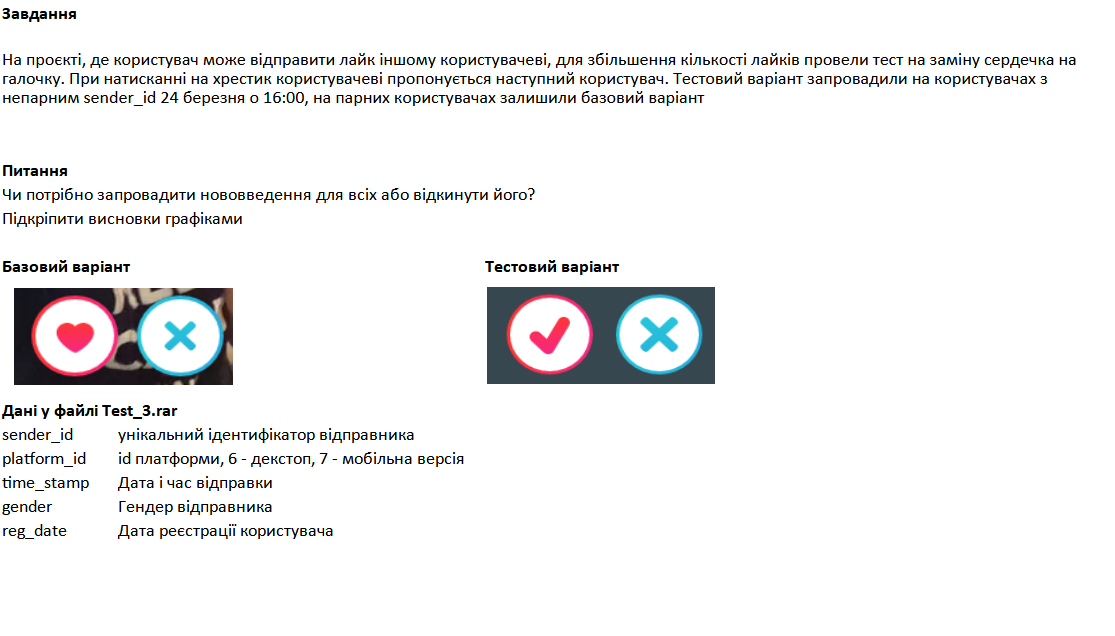

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu
from math import sqrt

In [2]:
df = pd.read_csv('/content/Test_4.csv',sep=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768439 entries, 0 to 768438
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   sender_id    768439 non-null  int64 
 1   platform_id  768439 non-null  int64 
 2   time_stamp   768439 non-null  object
 3   gender       768439 non-null  object
 4   reg_date     768439 non-null  object
dtypes: int64(2), object(3)
memory usage: 29.3+ MB


In [4]:
test_start = '2017-03-24 16:00:00'

In [5]:
df['reg_date'] = pd.to_datetime(df['reg_date'])
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df = df[df['time_stamp'] >= test_start]

/tmp/ipython-input-1551205719.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['reg_date'] = pd.to_datetime(df['reg_date'])
/tmp/ipython-input-1551205719.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['time_stamp'] = pd.to_datetime(df['time_stamp'])


In [6]:
df['time_stamp'].max()

Timestamp('2017-03-27 00:00:00')

In [7]:
df['time_stamp'].min()

Timestamp('2017-03-24 16:00:00')

Уже дивно, тест тривав 2.5 дні.Тести зазвичай тривають 7-14 днів.

Надійний статистичний висновок зробити не можна — потрібен довший тест або додаткові дані

In [8]:
df['group'] = np.where(df['sender_id'] % 2 == 0, 'control', 'test')

In [9]:
likes_per_user = df.groupby(["group", "sender_id"]).size().reset_index(name="likes")

In [10]:
likes_per_user

,group,sender_id,likes
0,control,3201946084,3
1,control,3201948046,21
2,control,3201948762,7
3,control,3201991474,16
4,control,3202014542,15
...,...,...,...
7328,test,3219308377,103
7329,test,3219308455,20
7330,test,3219309969,8
7331,test,3219310125,4


Перевіряю збалансованість груп для того щоб бути впевненим,що зміни викликані зміною кнопки

In [11]:
print("Кількість користувачів у групах:")
print(likes_per_user.groupby('group')['sender_id'].count())

print("Розподіл за платформами:")
print(df.groupby(['group','platform_id'])['sender_id'].nunique())

print("Розподіл за статтю:")
print(df.groupby(['group','gender'])['sender_id'].nunique())

Кількість користувачів у групах:
group
control    3726
test       3607
Name: sender_id, dtype: int64
Розподіл за платформами:
group    platform_id
control  6              1707
         7              2057
test     6              1654
         7              2001
Name: sender_id, dtype: int64
Розподіл за статтю:
group    gender
control  f          856
         m         2870
test                  2
         f          794
         m         2811
Name: sender_id, dtype: int64


In [12]:
metrics = likes_per_user.groupby("group")["likes"].agg(["mean", "std", "count"]).reset_index()
print("Метрики по групах:")
print(metrics)

Метрики по групах:
     group       mean        std  count
0  control  15.466452  44.782857   3726
1     test  13.851955  26.280121   3607


In [13]:
control = likes_per_user[likes_per_user["group"] == "control"]["likes"].to_numpy()
test = likes_per_user[likes_per_user["group"] == "test"]["likes"].to_numpy()

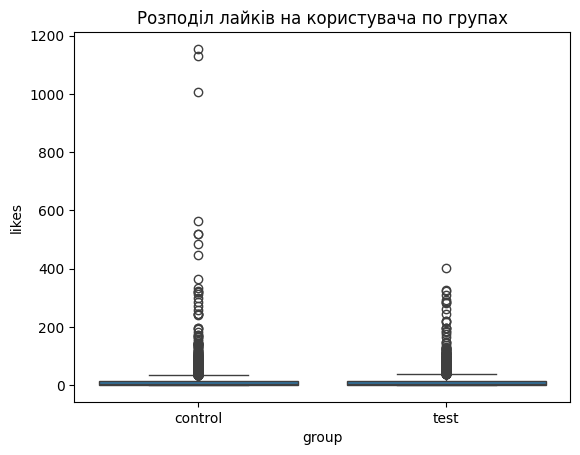

In [14]:
sns.boxplot(x="group", y="likes", data=likes_per_user)
plt.title("Розподіл лайків на користувача по групах")
plt.show()

У контрольній версії є викиди,щось з ними треба робити.Можна використати тест,на який викиди сильно не впливають

In [15]:
print(likes_per_user.groupby("group")["likes"].quantile([0.5,0.9,0.95,0.99]))

group        
control  0.50      5.00
         0.90     35.00
         0.95     55.00
         0.99    141.75
test     0.50      5.00
         0.90     35.00
         0.95     54.70
         0.99    112.94
Name: likes, dtype: float64


<Axes: ylabel='Density'>

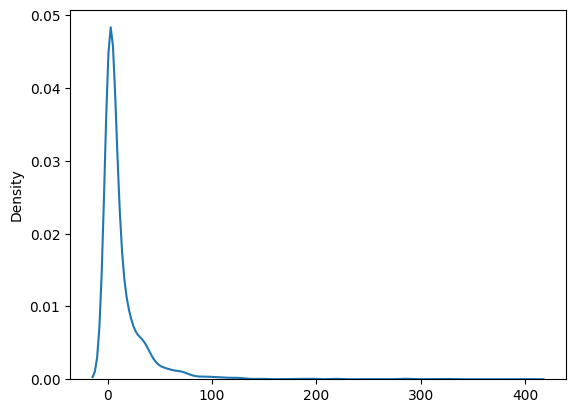

In [16]:
sns.kdeplot(test)

<Axes: ylabel='Density'>

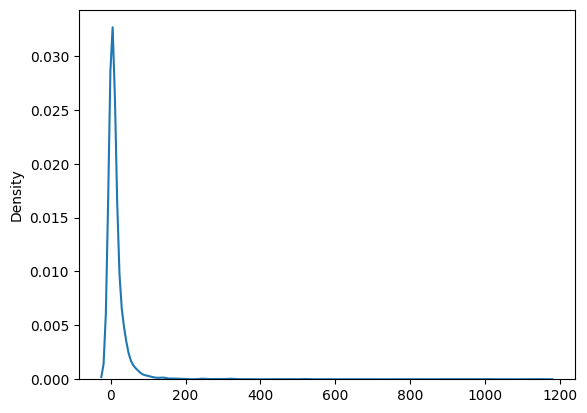

In [17]:
sns.kdeplot(control)

<Axes: ylabel='Density'>

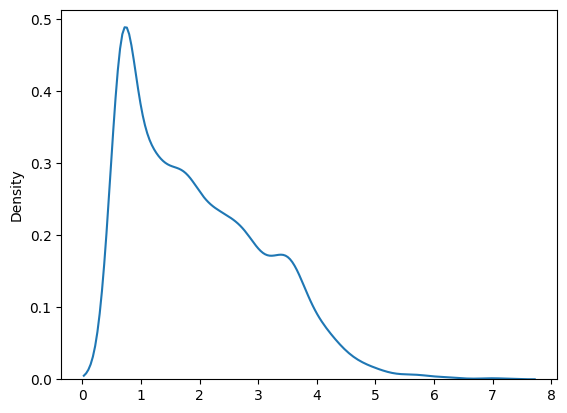

In [18]:
sns.kdeplot(np.log1p(control))

<Axes: ylabel='Density'>

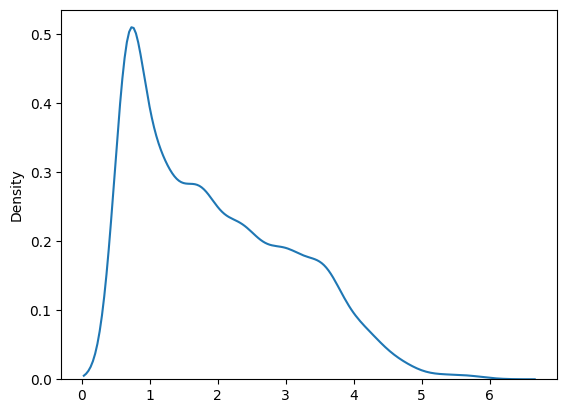

In [19]:
sns.kdeplot(np.log1p(test))

Прологарифмував вибірки,нормальний розподіл не вийшов :(

Вибірки мають не нормальний розподіл - тому t-test використати не можна.Можна використати Mann-Whitney U,в ньому не вимагається нормальність розподілу і він стійкий до викидів

* **Н0 :** середня кількість лайків на одного користувача в обох групах однакова

  $$
  H_0: \mu_A = \mu_B
  $$

* **H1 :** середня кількість лайків на одного користувача **відрізняється**

  $$
  H_1: \mu_A > \mu_B
  $$


In [20]:
def compare_groups(control, test, alpha=0.05):
    control = np.array(control)
    test = np.array(test)

    stat2, p2 = mannwhitneyu(test, control, alternative="two-sided")
    stat1, p1 = mannwhitneyu(test, control, alternative="greater")

    print(f"Двосторонній тест: U={stat2}, p-value={p2:.4f}")
    print(f"Односторонній тест (H1: test > control): U={stat1}, p-value={p1:.4f}")

    if p2 < alpha:
        print("Результати двостороннього тесту свідчать про статистично значущу різницю між групами.")
    else:
        print("Результати двостороннього тесту не підтверджують наявність статистично значущої різниці між групами.")

    if p1 < alpha:
        print("Односторонній тест показав, що середнє значення у тестовій групі є статистично значущо більшим, ніж у контрольній.")
    else:
        print("Односторонній тест не виявив статистично значущих доказів переваги тестової групи над контрольною.")

    print(f"Середнє значення у контрольній групі = {control.mean():.3f}")
    print(f"Середнє значення у тестовій групі    = {test.mean():.3f}")


In [21]:
compare_groups(control, test)

Двосторонній тест: U=6659900.0, p-value=0.5045
Односторонній тест (H1: test > control): U=6659900.0, p-value=0.7478
Результати двостороннього тесту не підтверджують наявність статистично значущої різниці між групами.
Односторонній тест не виявив статистично значущих доказів переваги тестової групи над контрольною.
Середнє значення у контрольній групі = 15.466
Середнє значення у тестовій групі    = 13.852


Зроблю тест для обрізаних даних.Це крок для перевірки надійності.

Раптом весь ефект був викликаний кількома "суперактивними" користувачами, які потрапили в тестову групу

In [22]:
q_control = np.quantile(control, 0.99)
q_test = np.quantile(test, 0.99)

In [23]:
control_trimmed = control[control <= q_control]
test_trimmed = test[test <= q_test]

<Axes: ylabel='Density'>

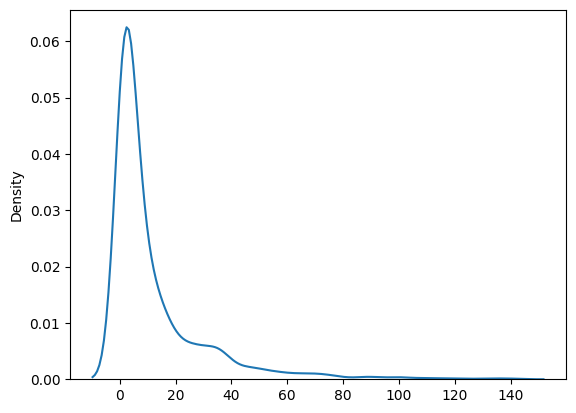

In [24]:
sns.kdeplot(control_trimmed)

<Axes: ylabel='Density'>

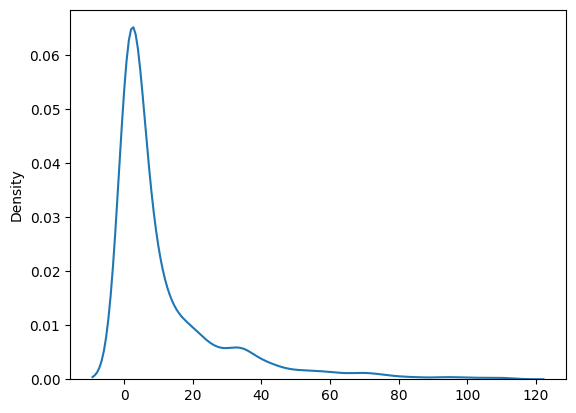

In [25]:
sns.kdeplot(test_trimmed)

In [26]:
print(f"Розмір control після обрізання: {len(control_trimmed)} (було {len(control)})")
print(f"Розмір test після обрізання: {len(test_trimmed)} (було {len(test)})")

Розмір control після обрізання: 3688 (було 3726)
Розмір test після обрізання: 3570 (було 3607)


In [27]:
compare_groups(control_trimmed, test_trimmed)

Двосторонній тест: U=6523183.5, p-value=0.4980
Односторонній тест (H1: test > control): U=6523183.5, p-value=0.7510
Результати двостороннього тесту не підтверджують наявність статистично значущої різниці між групами.
Односторонній тест не виявив статистично значущих доказів переваги тестової групи над контрольною.
Середнє значення у контрольній групі = 12.228
Середнє значення у тестовій групі    = 11.993


Середня кількість лайків на користувача у тестовій групі (галочка замість сердечка) не відрізняється від контрольної групи (старий дизайн).

Статистично значущої різниці між групами не виявлено (Mann–Whitney тест), навіть після перевірки без топ-1% найактивніших користувачів.

Варто провести повторний тест на довшому періоді (7–14 днів) і з більшою кількістю користувачів, щоб забезпечити статистичну надійність результатів.